### 1.0 -Load libraries
In our Second Hand Car Price Prediction project we used SXBoost, mada score

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # library for visualization
import seaborn as sns # library for visualization
import warnings
import os
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

warnings.filterwarnings('ignore')
sns.set_palette('Spectral')
sns.set_context('notebook', font_scale=1)
sns.set_style('whitegrid')
# set pandas 3 digits decimal
pd.set_option('display.float_format', '{:.3f}'.format)

<p> Note to self: <br>
1- Load the initial data, clean car data that can cause false calculations. + <br>
2- Edit all the data into ML friendly numerical values. <--- <br>
3- Fill, complete missing values <br>
4- Try the ML algorithms: KNN, XGBoost, min-max norm, <br>
5- Start building the web app
</p>

<h4> 1.1 Load the available data </h4>

In [2]:
dir = 'vehicles-random-subset-ThisOne-minMaxNorm.csv'
with open(dir, mode='r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader, None)
    
# print first 5 recording of data
df=pd.read_csv(dir)
df.columns = df.columns.str.lower()  # Convert all column names to lowercase
print(df.head(5))
print()
print(df.columns)


   year manufacturer            model   condition cylinders fuel  odometer  \
0 0.009         ford         m-deluxe   excellent         6  gas     0.002   
1 0.009    chevrolet   'm-3100 truck'        good         6  gas     0.003   
2 0.009         ford          m-sedan        good         8  gas     0.005   
3 0.009    chevrolet  'm-sport coupe'   excellent         8  gas     0.001   
4 0.009    chevrolet  'm-sport coupe'  'like new'         8  gas     0.001   

  title_status transmission drive       size   type paint_color  price  
0        clean       manual   rwd  full-size  sedan       black   9500  
1        clean       manual   rwd  full-size  truck       green  16000  
2        clean       manual   fwd   mid-size  sedan       green  18000  
3        clean    automatic   rwd   mid-size  coupe      yellow  22000  
4        clean    automatic   rwd   mid-size  coupe      yellow  22000  

Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer',

#### 1.2 Scrape data from internet and append the data to available data

This is done to increase amount of data and to increase coherence.

In [3]:
#get further data, clean it and then append to the vehicles-random-subset.csv
# ATTRIBUTES ARE:
#['year','manufacturer','model','condition','cylinders','fuel','odometer','title_status','transmission','drive','size','type','paint_color','price']

### Conversion of categorical data into numerical data

In [4]:
# Columns to encode
columns_to_encode = ['manufacturer', 'model', 'condition','cylinders', 'fuel', 'title_status','transmission', 'size', 'type','paint_color']

# One-hot encode the specified columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
# Display the transformed DataFrame
print(df_encoded.head(5))



   year  odometer drive  price  manufacturer_alfa-romeo  \
0 0.009     0.002   rwd   9500                    False   
1 0.009     0.003   rwd  16000                    False   
2 0.009     0.005   fwd  18000                    False   
3 0.009     0.001   rwd  22000                    False   
4 0.009     0.001   rwd  22000                    False   

   manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
0                      False              False             False   
1                      False              False             False   
2                      False              False             False   
3                      False              False             False   
4                      False              False             False   

   manufacturer_buick  manufacturer_cadillac  ...  paint_color_brown  \
0               False                  False  ...              False   
1               False                  False  ...              False   
2             

## HANDLING MISSING VALUES

Skewness: 39.197325787865374


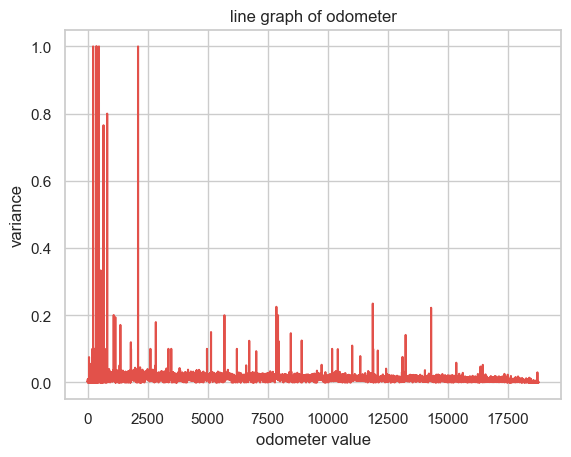

year       -2.452
odometer   39.197
price       2.333
dtype: float64


In [5]:
import matplotlib.pyplot as plt
skewness = df['odometer'].skew()
print(f"Skewness: {skewness}")
df['odometer'].plot(kind='line')
plt.title('line graph of odometer')
plt.xlabel('odometer value')
plt.ylabel('variance')
plt.show()
df['odometer'] = df['odometer'].fillna(df['odometer'].median()) # HANDLING FOR SKEWED DATA
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(df[numerical_cols].skew())

df['year'] = df['year'].fillna(df['year'].mean()) # HANDLING FOR SYMMETRIC DATA

<h4> FILLING MISSING VALUES FOR CATEGORICAL DATA </h4>

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
# Columns to handle
categorical_columns = ['cylinders', 'fuel', 'transmission', 'type']
numerical_columns = ['year', 'odometer']  # Numerical columns

# Step 1: Replace "other" in categorical columns with the mode
for col in categorical_columns:
    mode_value = df[col].mode()[0]  # Find the mode
    df[col] = df[col].replace('other', mode_value)

# Step 2: Fill missing values in numerical columns with the median
for col in numerical_columns:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Step 3: Encode categorical columns for KNNImputer
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Step 4: Apply KNNImputer for further imputation
imputer = KNNImputer(n_neighbors=5)
columns_to_impute = numerical_columns + categorical_columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Step 5: Decode categorical columns back to original labels
for col in categorical_columns:
    df[col] = label_encoders[col].inverse_transform(df[col].round().astype(int))

# Step 6: Save the processed DataFrame to a new CSV file
df.to_csv('filled_data.csv', index=False)

# Check the output
print("Processed data saved to 'filled_data.csv'.")



Processed data saved to 'filled_data.csv'.


### 3.0 Reducing Dimensions

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the dataset (replace with your dataset)
# df = pd.read_csv('filled_data.csv')

# Define features for PCA (exclude non-numeric or categorical columns if needed)
numerical_columns = ['year', 'odometer']  # Example numerical columns
categorical_columns = ['cylinders', 'fuel', 'model', 'condition', 'transmission', 'drive', 'title_status', 'size', 'type']

# Ensure categorical columns are numeric (if not already encoded)
for col in categorical_columns:
    df[col] = pd.Categorical(df[col]).codes

# Combine numerical and encoded categorical columns
features = numerical_columns + categorical_columns

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame with the PCA components
pca_columns = [f'PC{i+1}' for i in range(df_pca.shape[1])]
df_pca = pd.DataFrame(df_pca, columns=pca_columns)

# Save the transformed data to a CSV file
df_pca.to_csv('pca_transformed_data.csv', index=False)

# Check explained variance
print("Explained variance by each component:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())
print(f"PCA-transformed data saved to 'pca_transformed_data.csv'.")


Explained variance by each component: [0.14365219 0.12088699 0.10897427 0.09450916 0.09167112 0.08786322
 0.08616263 0.08221784 0.07709623 0.05819671]
Cumulative explained variance: [0.14365219 0.26453918 0.37351345 0.46802261 0.55969373 0.64755696
 0.73371958 0.81593742 0.89303365 0.95123036]
PCA-transformed data saved to 'pca_transformed_data.csv'.


Explained variance (PC1, PC2): [0.92461872 0.05306648]


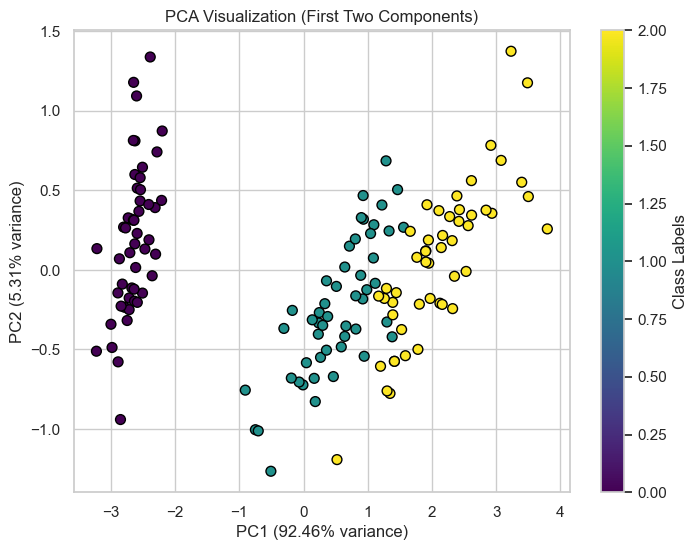

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris  # Replace with your dataset

# Load sample data (replace with your data)
data = load_iris()
X = data.data  # Replace with your dataset
y = data.target  # Labels for coloring (optional)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance (PC1, PC2): {explained_variance}")

# Plot PCA result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}% variance)")
plt.title("PCA Visualization (First Two Components)")
plt.colorbar(scatter, label="Class Labels")  # Optional for labeled data
plt.grid(True)
plt.show()


### 2.0 Train/Test splitting

All the collected data needs to be split to test, train. We will split 20/80 = test/train

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df_pca = pd.read_csv('pca_transformed_data.csv')
# df_target = pd.read_csv('target_column.csv')

# If PCA output is already a DataFrame:
target = 'price' # Replace 'target_column' with your target data

# Split PCA-transformed data into features and target
X = df_pca  # PCA-transformed features
y = target  # Target column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model (Random Forest in this example)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


ValueError: Found input variables with inconsistent numbers of samples: [18775, 5]

In [43]:
#features (X) and target (y)
X = df.drop(columns='price')
y = df['price']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost regressor

In [44]:
"""import xgboost
print(xgboost.__version__)
# Train an XGBoost regressor model
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)"""

"import xgboost\nprint(xgboost.__version__)\n# Train an XGBoost regressor model\nxgb_model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)\nxgb_model.fit(X_train, y_train)"